In [1]:
import torchvision as tv
import time
from torch import nn
from matplotlib import pyplot as plt
from torchsummary import summary
import torch

In [2]:
target_acc = 0.895
# заданный порог для тестовой выборки

In [3]:
model_dict = {
    "model_name": [],
    "ep": [],
    "taked": [],
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}
# словарь для хранения результатов моделей

#### Функция для построения графиков по результатам обучения и тестирования разных моделей.

Рисует пять графиков и легенду

Аргументы:
- model_dict - словарь, содержащий списки значений для эпох, времени, потерь и точности для каждой модели.
- best_list (необязательный) - список, содержащий имена моделей, которые отображаются на графиках

In [4]:
def plt_show(model_dict, best_list = []):
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20,20))
    fig.suptitle('Plots')
    leg = axs[0, 0]
    ax1 = axs[0, 1]
    ax2 = axs[1, 0]
    ax3 = axs[1, 1]
    ax4 = axs[2, 0]
    ax5 = axs[2, 1]

    for x, y, label in zip(model_dict['ep'] , model_dict['taked'], model_dict['model_name']):
        if (best_list and label in best_list) or not best_list:
            ax1.plot(x , y, label=label)
    ax1.set_xlabel('ep')
    ax1.set_ylabel('taked')
    ax1.set_title('time')

    for x, y, label in zip(model_dict['ep'] , model_dict['train_loss'], model_dict['model_name']):
        if (best_list and label in best_list) or not best_list:
            ax2.plot(x , y)
    ax2.set_xlabel('ep')
    ax2.set_ylabel('train_loss')
    ax2.set_title('train loss')

    for x, y, label in zip(model_dict['ep'] , model_dict['train_acc'], model_dict['model_name']):
        if (best_list and label in best_list) or not best_list:
            ax3.plot(x , y)
    ax3.set_xlabel('ep')
    ax3.set_ylabel('train_acc')
    ax3.set_title('train accuracy')

    for x, y, label in zip(model_dict['ep'] , model_dict['test_loss'], model_dict['model_name']):
        if (best_list and label in best_list) or not best_list:
            ax4.plot(x , y)
    ax4.set_xlabel('ep')
    ax4.set_ylabel('test_loss')
    ax4.set_title('test loss')

    for x, y, label in zip(model_dict['ep'] , model_dict['test_acc'], model_dict['model_name']):
        if (best_list and label in best_list) or not best_list:
            ax5.plot(x , y)
    ax5.set_xlabel('ep')
    ax5.set_ylabel('test_acc')
    ax5.set_title('test accuracy')
    
    ax5.axhline(y=target_acc, color='red', linestyle='--', label='Threshold')
    
    leg.legend(*ax1.get_legend_handles_labels(), loc=2)
    leg.axis("off")

In [5]:
def train(optimizer, num_epochs, model_name_):
    ep_ = []
    taked_ = []
    train_loss_ = []
    train_acc_ = []
    test_loss_ = []
    test_acc_ = []
    
    loss = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, train_n, start = 0.0, 0.0, 0, time.time()
    
        for X, y in train_iter:
            optimizer.zero_grad()
            y_hat = model(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            train_n += y.shape[0]
        
        test_l_sum, test_acc_sum, test_n = 0.0, 0.0, 0
        
        model.eval()
        for X, y in test_iter:
            y_hat = model(X)
            l = loss(y_hat, y)
            test_l_sum += l.item()
            test_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            test_n += y.shape[0]
            
        ep_.append(epoch)
        taked_.append(time.time() - start)
        train_loss_.append(train_l_sum / train_n)
        train_acc_.append(train_acc_sum / train_n)
        test_loss_.append(test_l_sum / test_n)
        test_acc_.append(test_acc_sum / test_n)
    
        print(f'epoch {epoch}, train loss {train_l_sum / train_n:.4f}, train acc {train_acc_sum / train_n:.3f}' \
              f', test loss {test_l_sum / test_n:.4f}, test acc {test_acc_sum / test_n:.3f}' \
              f', time {time.time() - start:.1f} sec')
    
    model_dict['model_name'].append(model_name_)
    model_dict['ep'].append(ep_)
    model_dict['taked'].append(taked_)
    model_dict['train_loss'].append(train_loss_)
    model_dict['train_acc'].append(train_acc_)
    model_dict['test_loss'].append(test_loss_)
    model_dict['test_acc'].append(test_acc_)

## Скачивание тренировочной и тестовой части датасета Fashion MNIST
[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist)

In [6]:
BATCH_SIZE=256
train_dataset = tv.datasets.FashionMNIST('.', train=True, transform=tv.transforms.ToTensor(), download=True)
test_dataset = tv.datasets.FashionMNIST('.', train=False, transform=tv.transforms.ToTensor(), download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

## Построение архитектуры модели, 
используем
- свёрточные слои, 
- слои регуляризации 
- и один финальный полносвязный слой

In [7]:
model = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=3),
    nn.ReLU(),
    nn.AvgPool2d(2, stride=2),
    nn.Dropout(0.2),
    nn.Conv2d(8, 16, kernel_size=4),
    nn.ReLU(),
    nn.AvgPool2d(2, stride=2),
    nn.Dropout(0.2),
    nn.Conv2d(16, 32, kernel_size=4),
    nn.Flatten(),
    nn.Linear(128, 10)
)

Модель имеет:
- три сверточных слоя (8-16-32 выходных каналов)
- два слоя регуляризация (Dropout)
- и один полносвязный слой

In [8]:
summary(model, input_size=(1, 28, 28), device='cpu')
# проверяем, что все размерности сходятся

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
              ReLU-2            [-1, 8, 26, 26]               0
         AvgPool2d-3            [-1, 8, 13, 13]               0
           Dropout-4            [-1, 8, 13, 13]               0
            Conv2d-5           [-1, 16, 10, 10]           2,064
              ReLU-6           [-1, 16, 10, 10]               0
         AvgPool2d-7             [-1, 16, 5, 5]               0
           Dropout-8             [-1, 16, 5, 5]               0
            Conv2d-9             [-1, 32, 2, 2]           8,224
          Flatten-10                  [-1, 128]               0
           Linear-11                   [-1, 10]           1,290
Total params: 11,658
Trainable params: 11,658
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

## Обучаем модель до необходимого качества

In [9]:
lr, num_epochs = 0.01, 20
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

model_name = 'Стартовая'
train(optimizer, num_epochs, model_name)

epoch 0, train loss 0.0090, train acc 0.112, test loss 0.0092, test acc 0.125, time 7.9 sec
epoch 1, train loss 0.0090, train acc 0.193, test loss 0.0092, test acc 0.202, time 7.4 sec
epoch 2, train loss 0.0088, train acc 0.259, test loss 0.0087, test acc 0.268, time 7.5 sec
epoch 3, train loss 0.0060, train acc 0.515, test loss 0.0043, test acc 0.626, time 7.4 sec
epoch 4, train loss 0.0035, train acc 0.679, test loss 0.0037, test acc 0.665, time 7.6 sec
epoch 5, train loss 0.0031, train acc 0.714, test loss 0.0031, test acc 0.718, time 7.5 sec
epoch 6, train loss 0.0029, train acc 0.731, test loss 0.0029, test acc 0.736, time 7.6 sec
epoch 7, train loss 0.0028, train acc 0.740, test loss 0.0029, test acc 0.742, time 7.4 sec
epoch 8, train loss 0.0027, train acc 0.746, test loss 0.0028, test acc 0.746, time 7.3 sec
epoch 9, train loss 0.0027, train acc 0.752, test loss 0.0027, test acc 0.749, time 7.4 sec
epoch 10, train loss 0.0026, train acc 0.756, test loss 0.0027, test acc 0.750, 

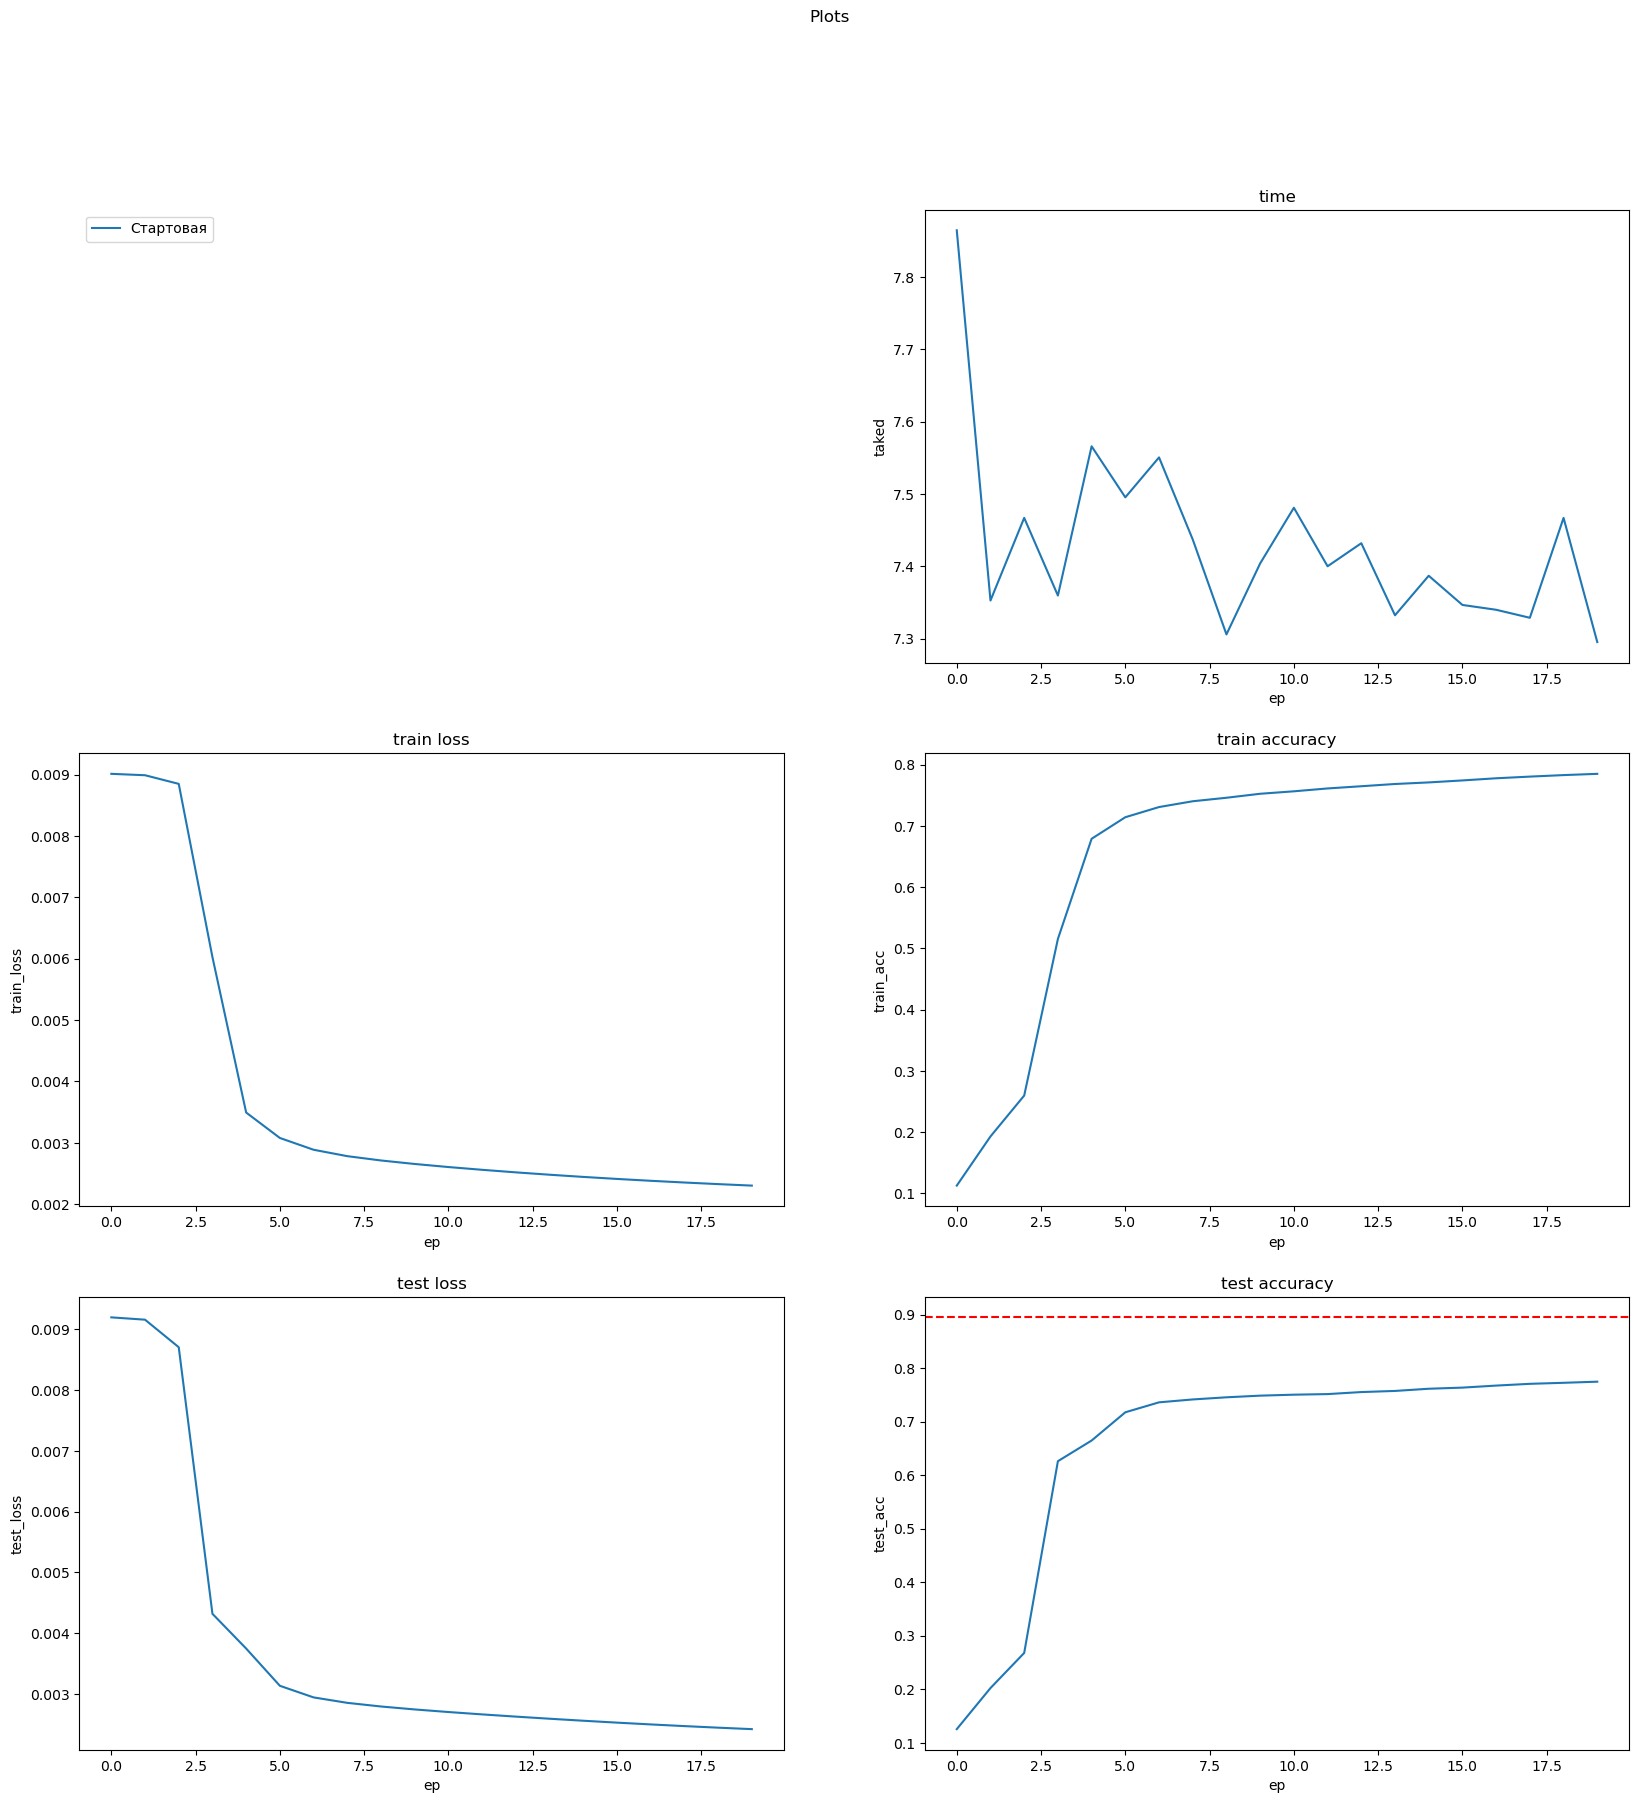

In [10]:
plt_show(model_dict)

на графике test accuracy проведен порог красной пунктирной линеей

## Меняем архитектуру сети

In [13]:
model = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Dropout(0.2),
    nn.Conv2d(8, 16, kernel_size=4),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Dropout(0.2),
    nn.Conv2d(16, 32, kernel_size=4),
    nn.Flatten(),
    nn.Linear(128, 10)
)
lr, num_epochs = 0.01, 20
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# меняем AvgPool2d на MaxPool2d

model_name = 'MaxPool2d'
train(optimizer, num_epochs, model_name)

epoch 0, train loss 0.0090, train acc 0.175, test loss 0.0090, test acc 0.319, time 8.4 sec
epoch 1, train loss 0.0078, train acc 0.417, test loss 0.0055, test acc 0.570, time 7.9 sec
epoch 2, train loss 0.0039, train acc 0.655, test loss 0.0035, test acc 0.691, time 8.0 sec
epoch 3, train loss 0.0031, train acc 0.703, test loss 0.0032, test acc 0.710, time 7.9 sec
epoch 4, train loss 0.0029, train acc 0.724, test loss 0.0030, test acc 0.730, time 7.9 sec
epoch 5, train loss 0.0027, train acc 0.739, test loss 0.0028, test acc 0.742, time 7.7 sec
epoch 6, train loss 0.0026, train acc 0.751, test loss 0.0027, test acc 0.748, time 7.7 sec
epoch 7, train loss 0.0025, train acc 0.761, test loss 0.0026, test acc 0.756, time 7.7 sec
epoch 8, train loss 0.0024, train acc 0.770, test loss 0.0025, test acc 0.763, time 8.0 sec
epoch 9, train loss 0.0023, train acc 0.779, test loss 0.0024, test acc 0.767, time 7.7 sec
epoch 10, train loss 0.0023, train acc 0.785, test loss 0.0023, test acc 0.775, 

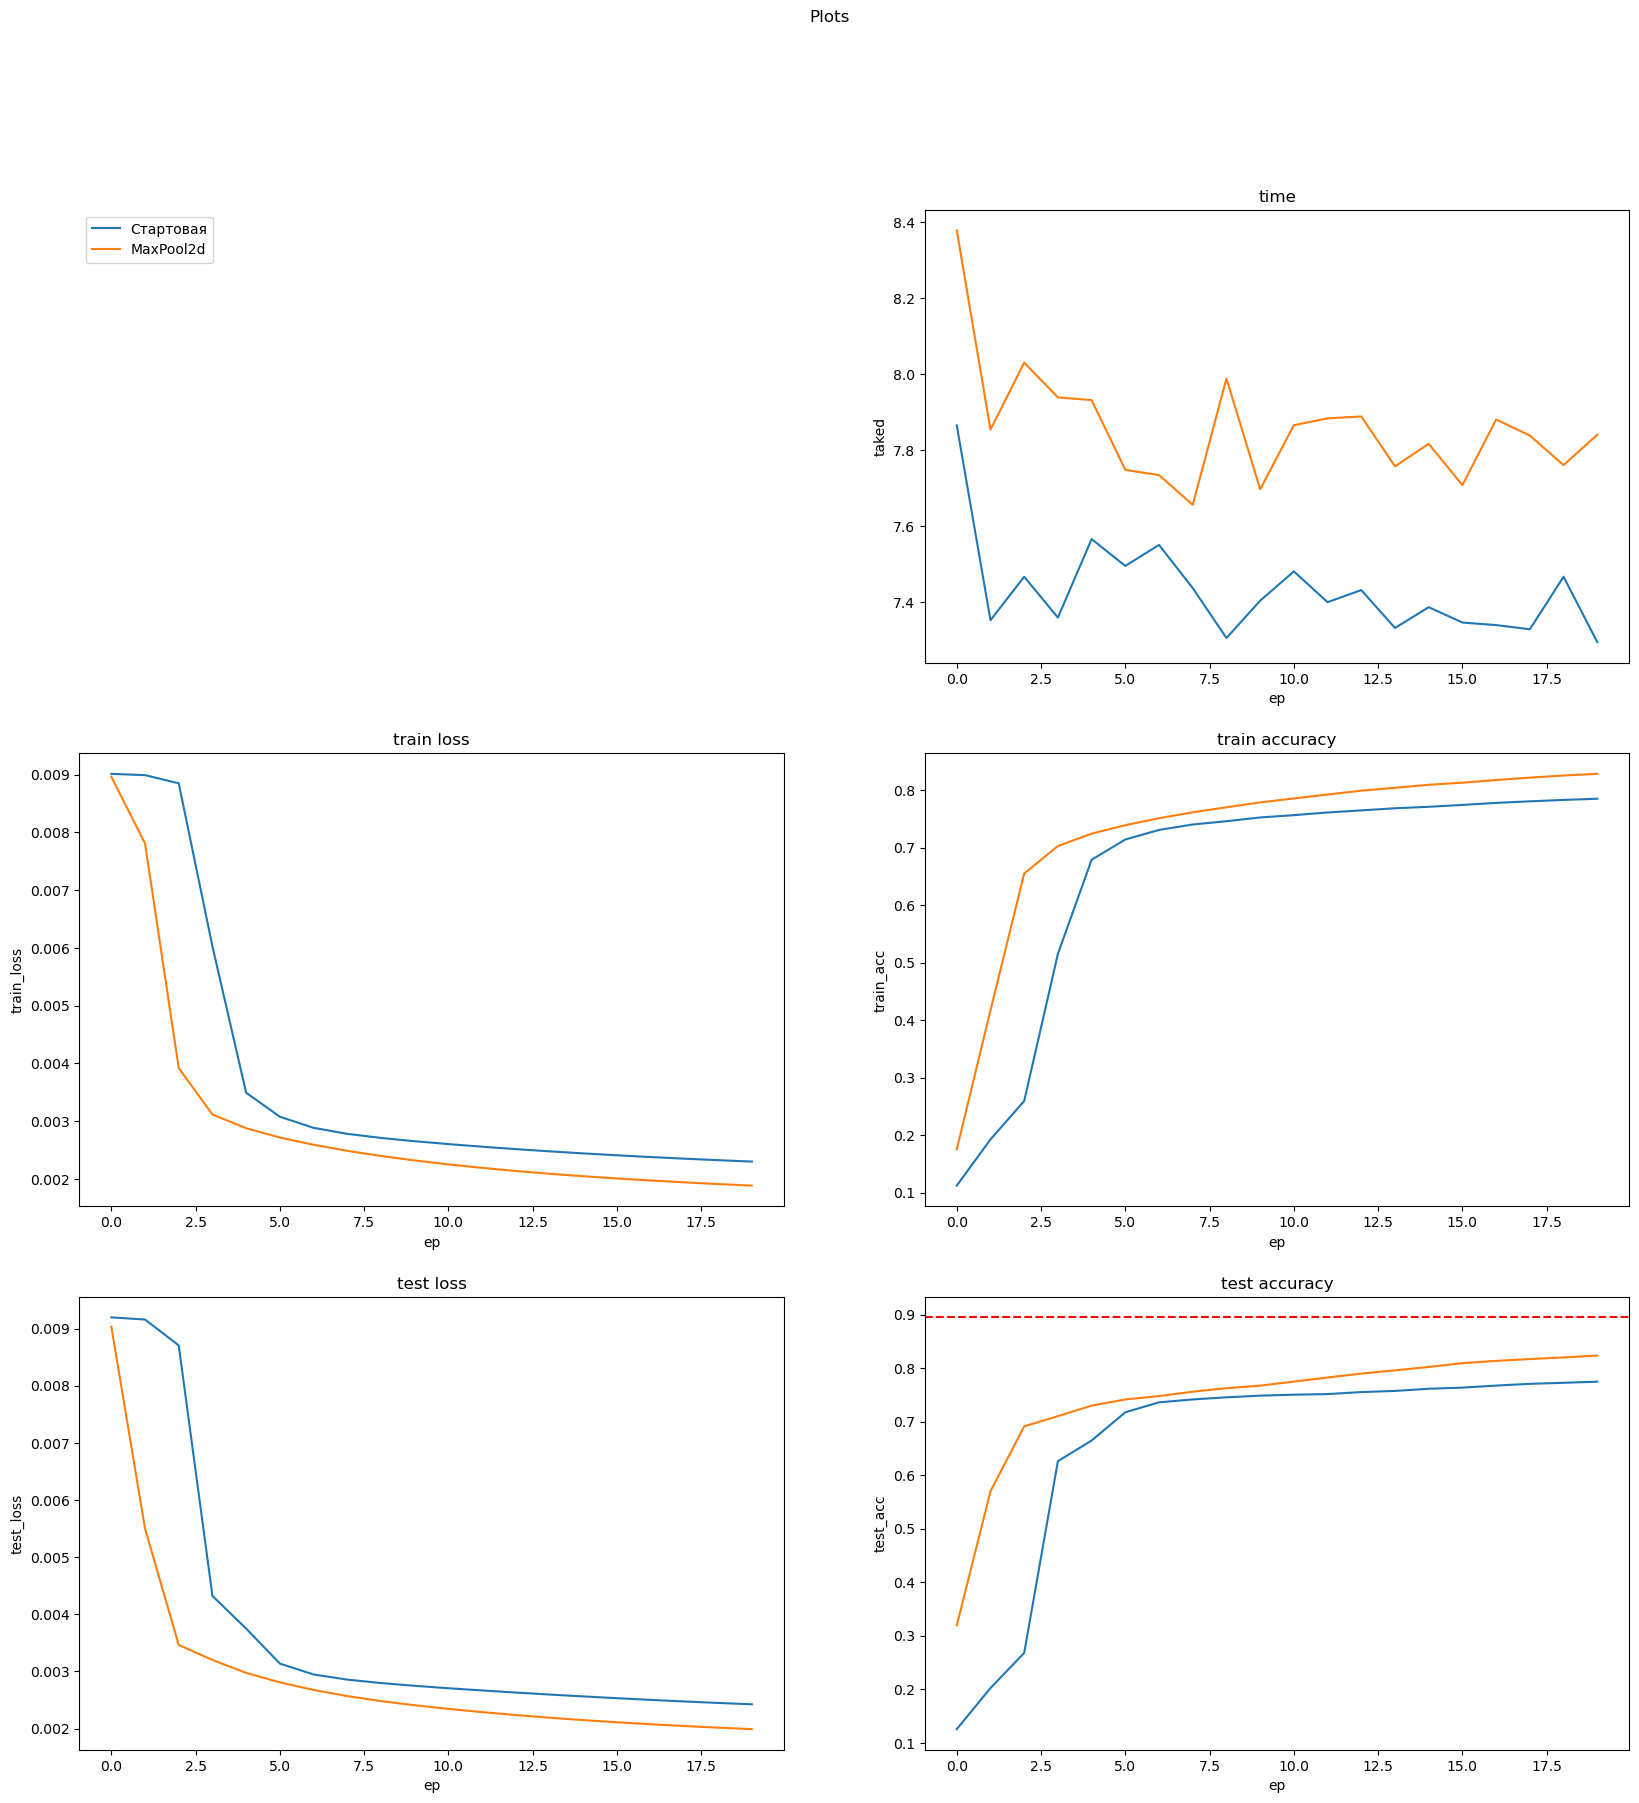

In [14]:
plt_show(model_dict, [
    'Стартовая',
    'MaxPool2d'
])

In [15]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Dropout(0.2),
    nn.Conv2d(16, 32, kernel_size=4),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Dropout(0.2),
    nn.Conv2d(32, 64, kernel_size=4),
    nn.Flatten(),
    nn.Linear(256, 10)
)
lr, num_epochs = 0.01, 20
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# увеличим кол-во каналов первого сверточного слоя до 16

model_name = 'out_channels (16-32-64)'
train(optimizer, num_epochs, model_name)

epoch 0, train loss 0.0088, train acc 0.223, test loss 0.0085, test acc 0.449, time 13.6 sec
epoch 1, train loss 0.0054, train acc 0.603, test loss 0.0039, test acc 0.646, time 12.7 sec
epoch 2, train loss 0.0033, train acc 0.690, test loss 0.0034, test acc 0.690, time 12.7 sec
epoch 3, train loss 0.0030, train acc 0.715, test loss 0.0030, test acc 0.723, time 13.0 sec
epoch 4, train loss 0.0028, train acc 0.733, test loss 0.0028, test acc 0.737, time 12.7 sec
epoch 5, train loss 0.0026, train acc 0.746, test loss 0.0027, test acc 0.744, time 12.5 sec
epoch 6, train loss 0.0025, train acc 0.756, test loss 0.0026, test acc 0.752, time 12.1 sec
epoch 7, train loss 0.0024, train acc 0.765, test loss 0.0025, test acc 0.759, time 11.9 sec
epoch 8, train loss 0.0024, train acc 0.773, test loss 0.0024, test acc 0.766, time 11.4 sec
epoch 9, train loss 0.0023, train acc 0.780, test loss 0.0024, test acc 0.772, time 11.2 sec
epoch 10, train loss 0.0022, train acc 0.787, test loss 0.0023, test a

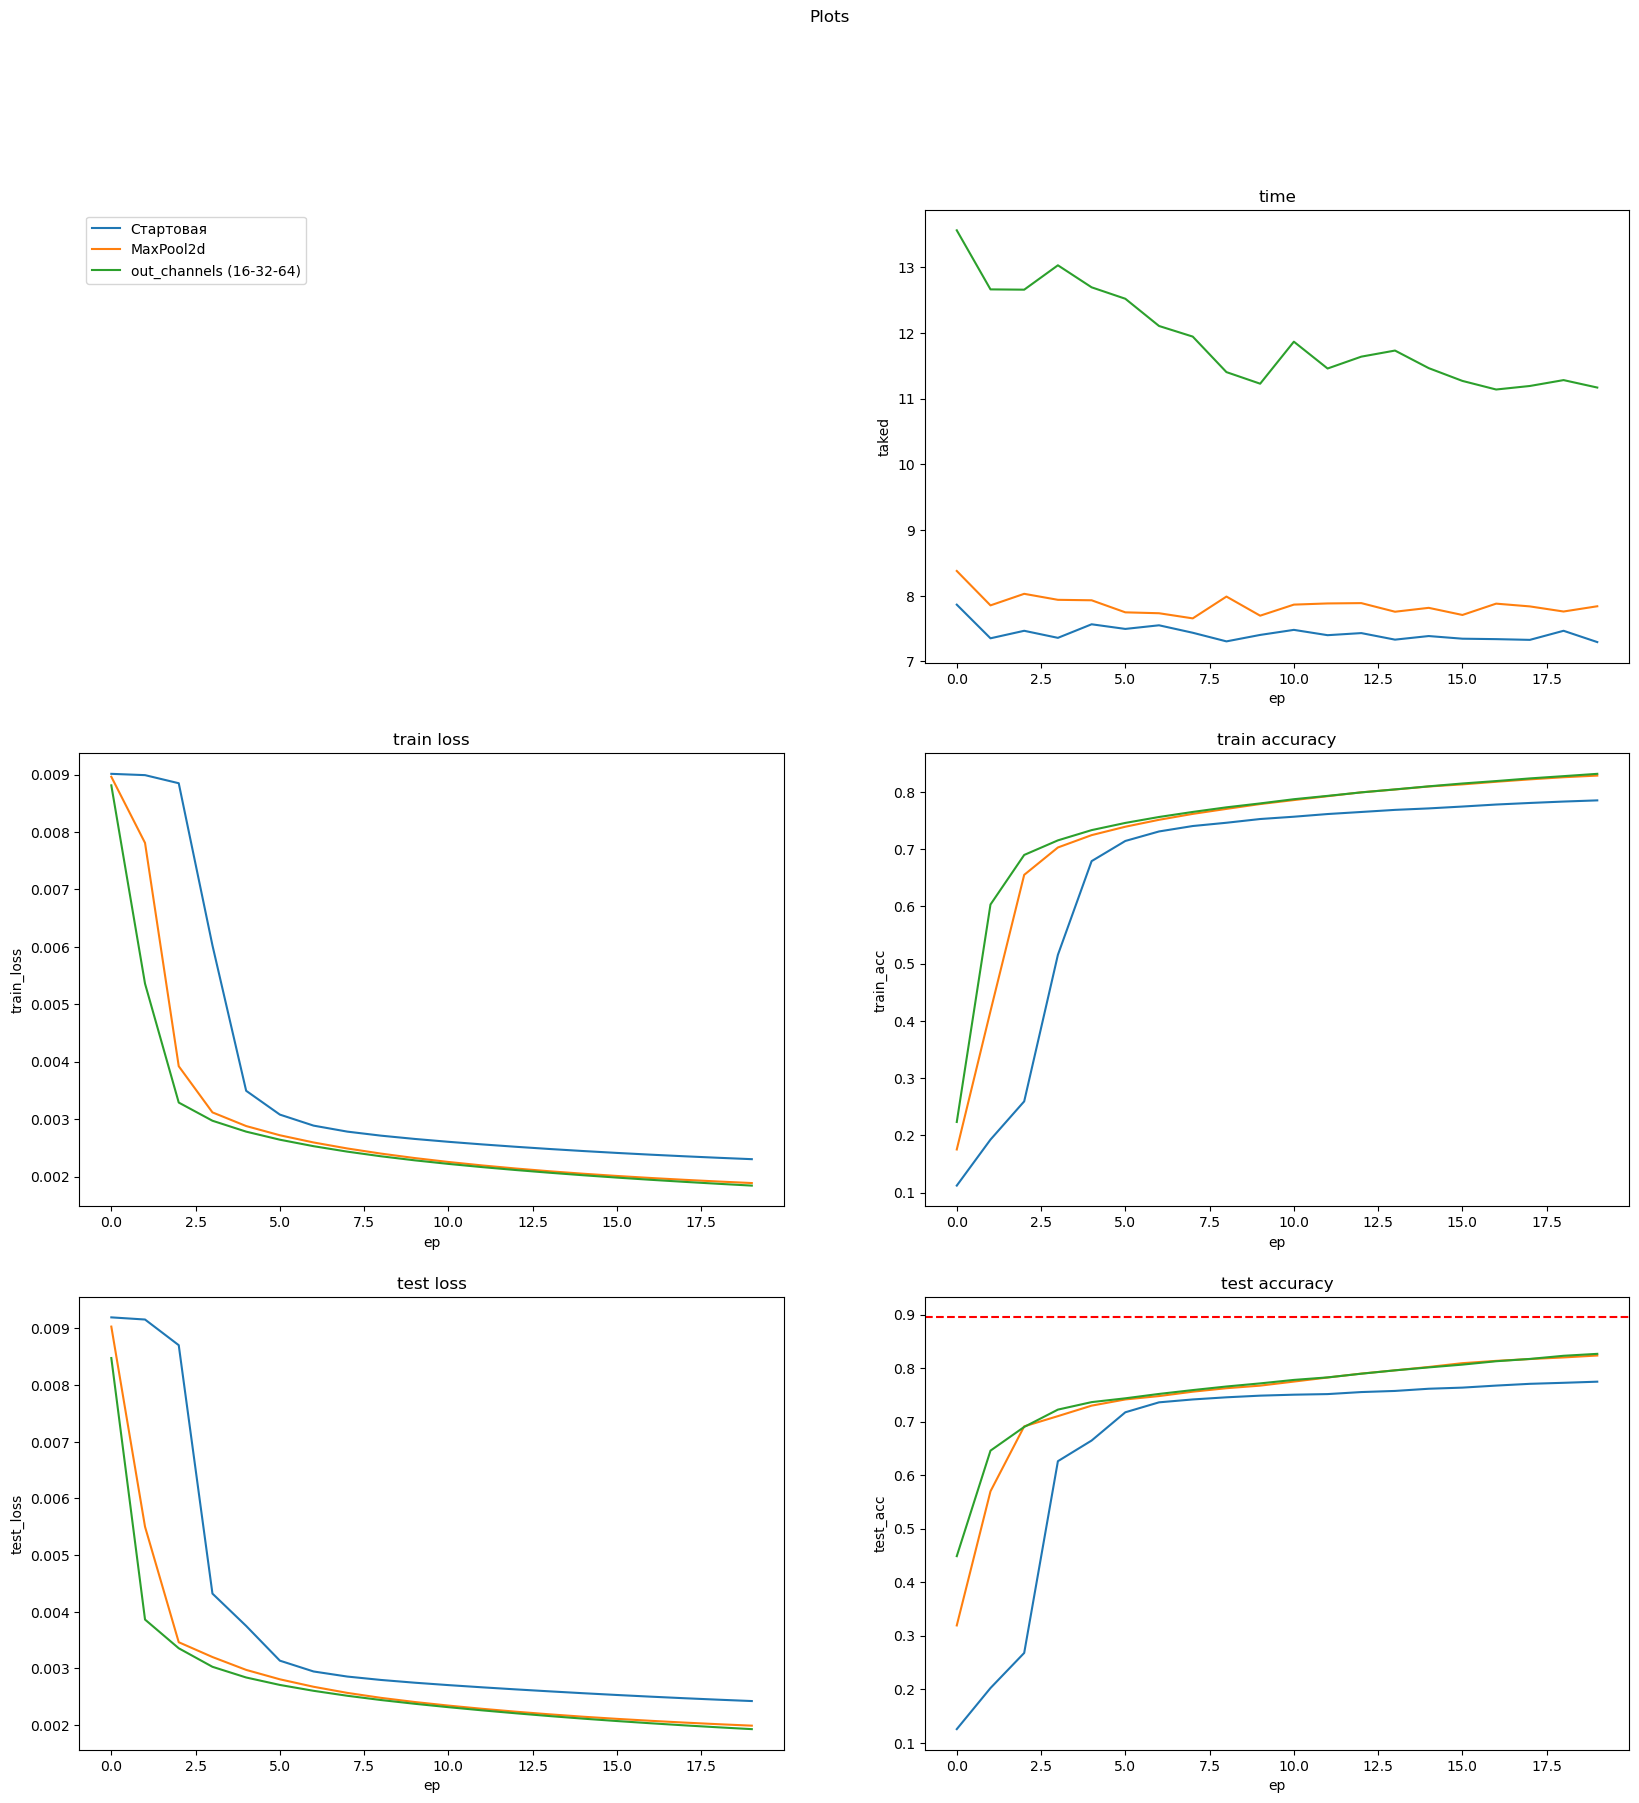

In [16]:
plt_show(model_dict, [
    'Стартовая',
    'MaxPool2d',
    'out_channels (16-32-64)'
])

In [17]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Dropout(0.2),
    nn.Conv2d(16, 32, kernel_size=4),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Dropout(0.2),
    nn.Conv2d(32, 64, kernel_size=4),
    nn.Flatten(),
    nn.Linear(256, 10)
)
lr, num_epochs = 0.001, 20
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# меняем оптимизатор на Adam и уменьшим скорость обучения

model_name = 'Adam (0.001)'
train(optimizer, num_epochs, model_name)

epoch 0, train loss 0.0030, train acc 0.714, test loss 0.0022, test acc 0.784, time 11.8 sec
epoch 1, train loss 0.0018, train acc 0.837, test loss 0.0018, test acc 0.841, time 11.3 sec
epoch 2, train loss 0.0015, train acc 0.865, test loss 0.0016, test acc 0.858, time 11.2 sec
epoch 3, train loss 0.0014, train acc 0.877, test loss 0.0015, test acc 0.867, time 11.4 sec
epoch 4, train loss 0.0013, train acc 0.886, test loss 0.0014, test acc 0.877, time 11.4 sec
epoch 5, train loss 0.0012, train acc 0.893, test loss 0.0014, test acc 0.882, time 11.7 sec
epoch 6, train loss 0.0011, train acc 0.898, test loss 0.0013, test acc 0.884, time 11.3 sec
epoch 7, train loss 0.0011, train acc 0.903, test loss 0.0013, test acc 0.884, time 11.4 sec
epoch 8, train loss 0.0010, train acc 0.906, test loss 0.0013, test acc 0.887, time 11.7 sec
epoch 9, train loss 0.0010, train acc 0.909, test loss 0.0013, test acc 0.886, time 11.2 sec
epoch 10, train loss 0.0010, train acc 0.912, test loss 0.0013, test a

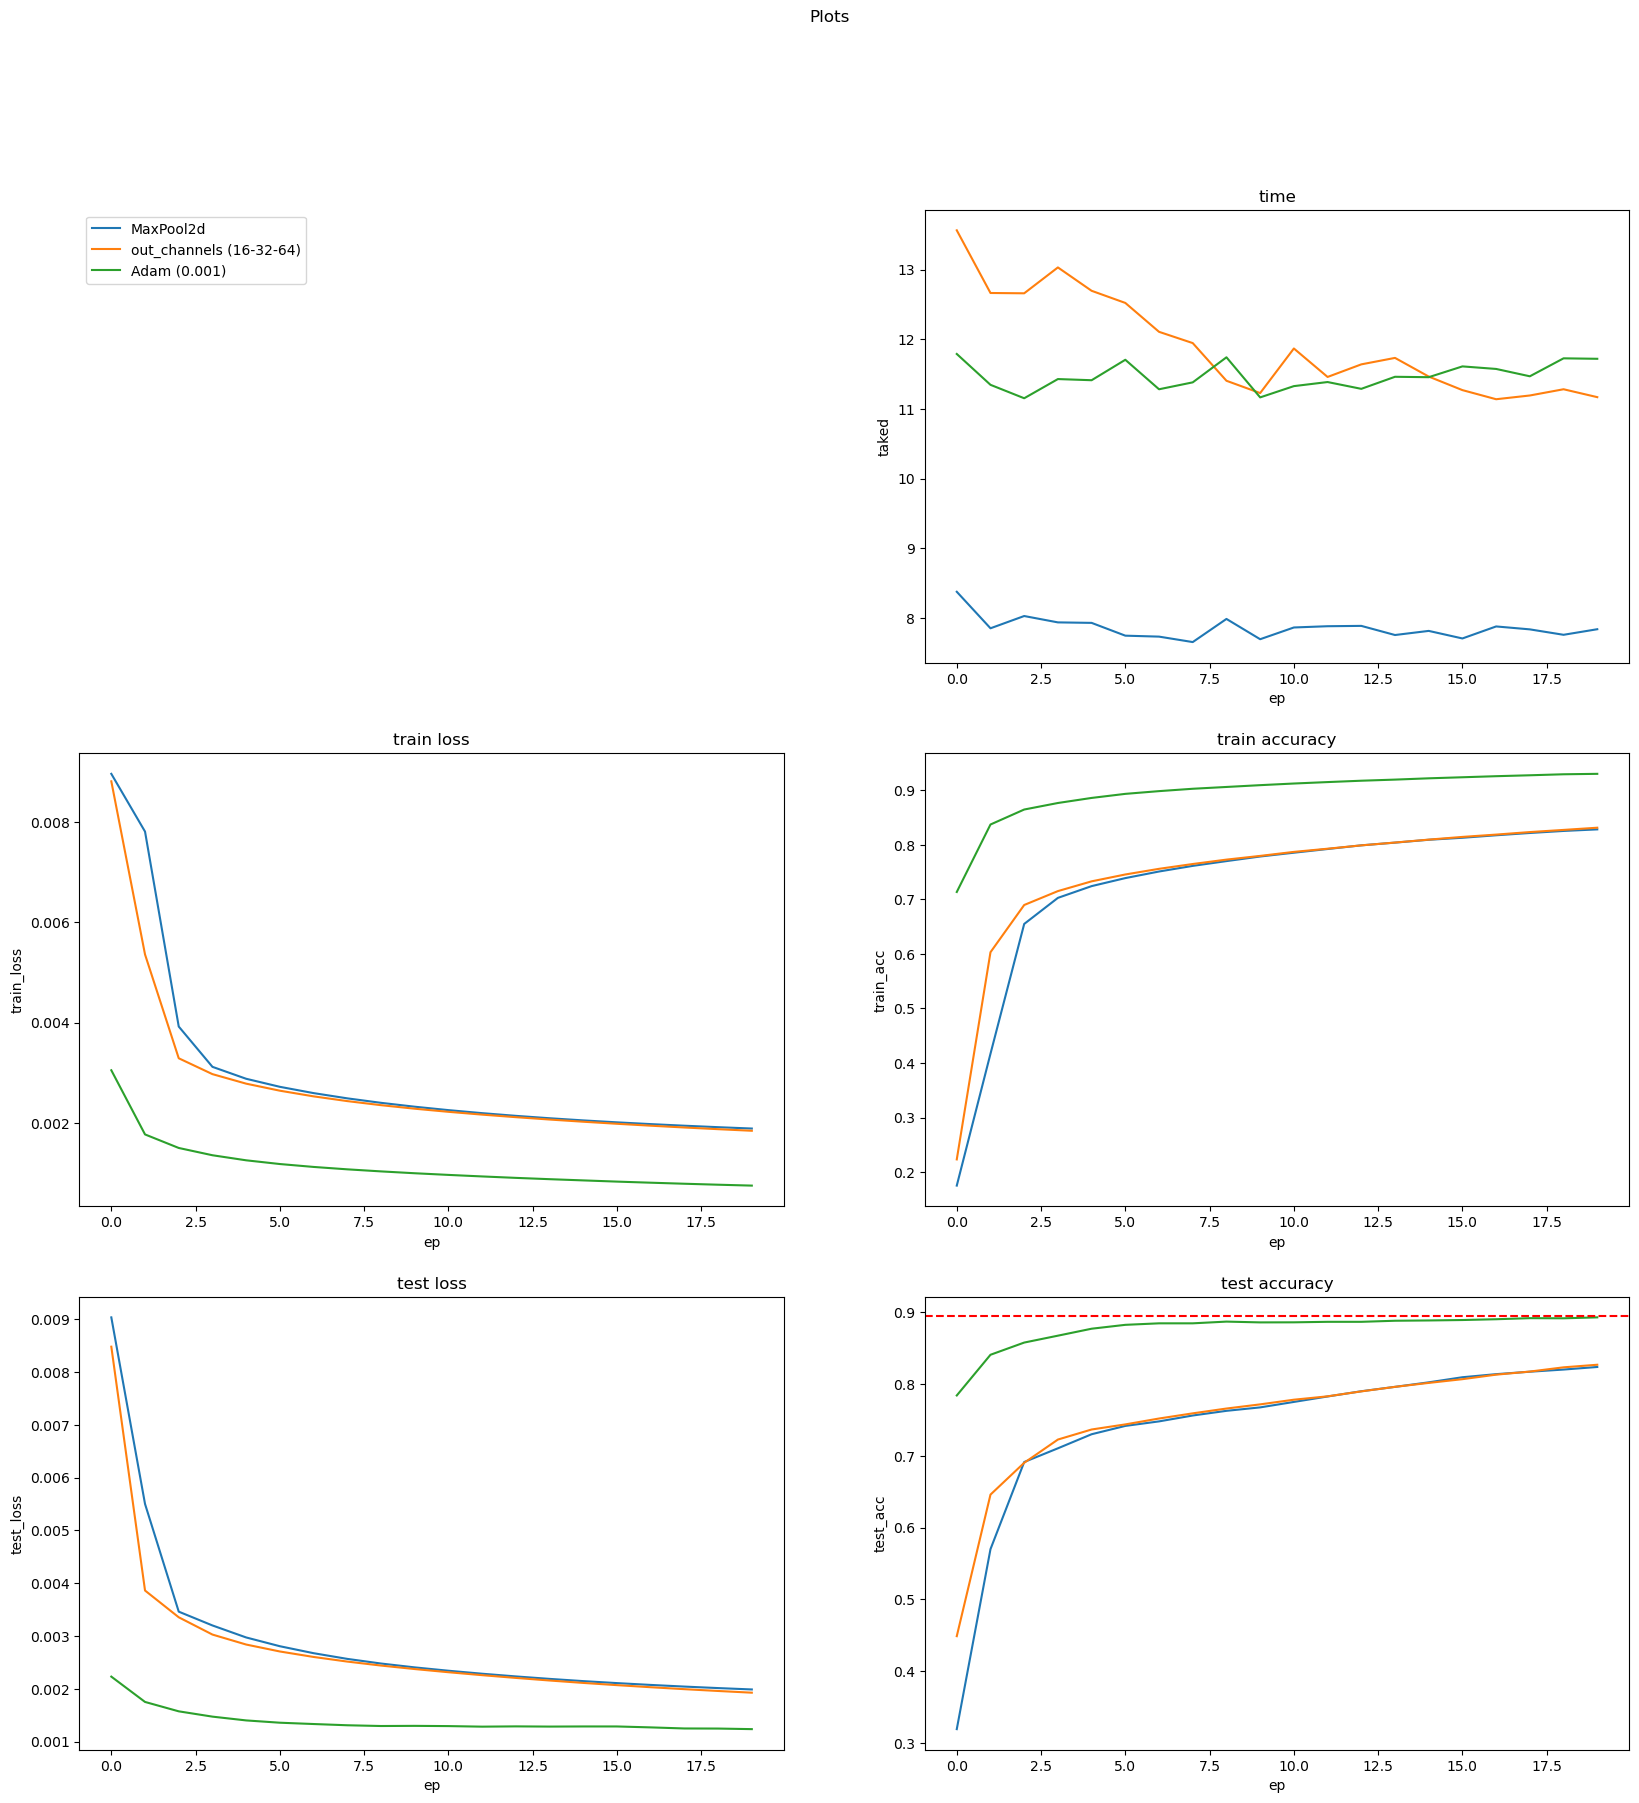

In [18]:
plt_show(model_dict, [
    'MaxPool2d',
    'out_channels (16-32-64)',
    'Adam (0.001)'
])

In [49]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Dropout(0.3),
    nn.Conv2d(16, 64, kernel_size=4),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Dropout(0.3),
    nn.Conv2d(64, 128, kernel_size=4),
    nn.MaxPool2d(2, stride=2),
    nn.Flatten(),
    nn.Linear(128, 10)
)
lr, num_epochs = 0.001, 20
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# изменим кол-во выходных каналов
# добавим в конце MaxPool2d
# повысим вероятность Dropout до 0.3

summary(model, input_size=(1, 28, 28), device='cpu')

model_name = 'out_channels (16-64-128) + Dropout(0.3)'
train(optimizer, num_epochs, model_name)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
              ReLU-2           [-1, 16, 26, 26]               0
         MaxPool2d-3           [-1, 16, 13, 13]               0
           Dropout-4           [-1, 16, 13, 13]               0
            Conv2d-5           [-1, 64, 10, 10]          16,448
              ReLU-6           [-1, 64, 10, 10]               0
         MaxPool2d-7             [-1, 64, 5, 5]               0
           Dropout-8             [-1, 64, 5, 5]               0
            Conv2d-9            [-1, 128, 2, 2]         131,200
        MaxPool2d-10            [-1, 128, 1, 1]               0
          Flatten-11                  [-1, 128]               0
           Linear-12                   [-1, 10]           1,290
Total params: 149,098
Trainable params: 149,098
Non-trainable params: 0
-------------------------------

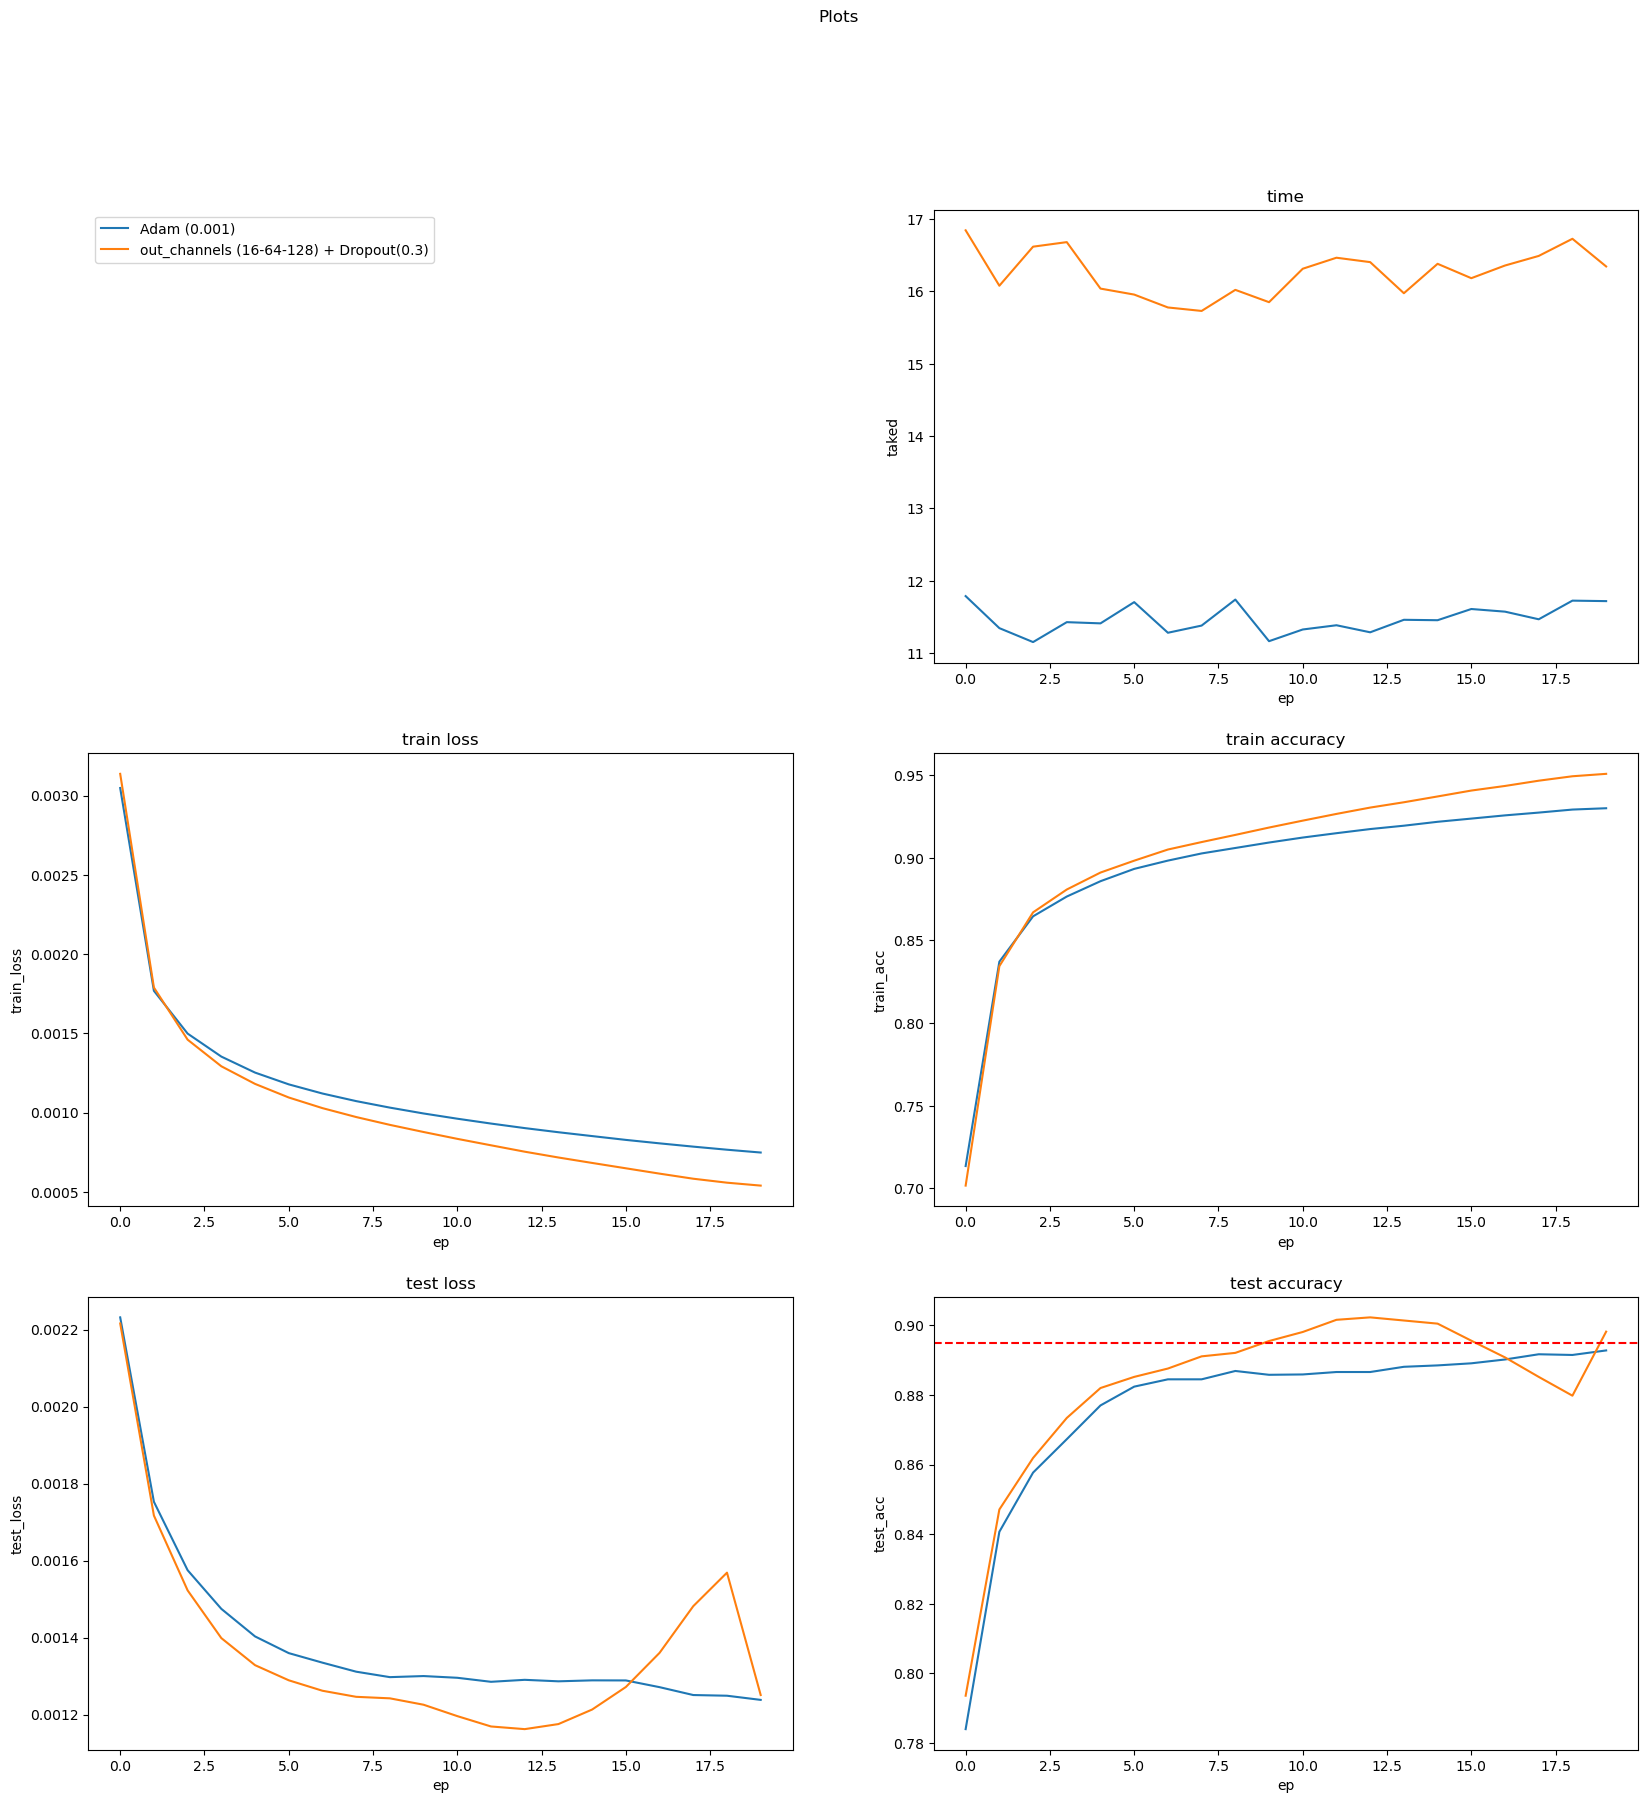

In [57]:
plt_show(model_dict, [
    'Adam (0.001)',
    'out_channels (16-64-128) + Dropout(0.3)'
])

В целом если обучать эту модель до 12 эпох, ты мы получим хороший результат.

Но подберем модель, которая не переобучается

In [54]:
model = nn.Sequential(
    nn.Conv2d(1, 12, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Dropout(0.3),
    nn.Conv2d(12, 48, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Dropout(0.3),
    nn.Conv2d(48, 96, kernel_size=3, padding=1),
    nn.MaxPool2d(2, stride=2),
    nn.Flatten(),
    nn.Linear(864, 10)
)
lr, num_epochs = 0.001, 20
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# изменим кол-во выходных каналов
# изменим размер ядер
# добавим padding чтобы не потерять информацию на краях

summary(model, input_size=(1, 28, 28), device='cpu')

model_name = 'out_channels (12-48-96)'
train(optimizer, num_epochs, model_name)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             120
              ReLU-2           [-1, 12, 26, 26]               0
         MaxPool2d-3           [-1, 12, 13, 13]               0
           Dropout-4           [-1, 12, 13, 13]               0
            Conv2d-5           [-1, 48, 13, 13]           5,232
              ReLU-6           [-1, 48, 13, 13]               0
         MaxPool2d-7             [-1, 48, 6, 6]               0
           Dropout-8             [-1, 48, 6, 6]               0
            Conv2d-9             [-1, 96, 6, 6]          41,568
        MaxPool2d-10             [-1, 96, 3, 3]               0
          Flatten-11                  [-1, 864]               0
           Linear-12                   [-1, 10]           8,650
Total params: 55,570
Trainable params: 55,570
Non-trainable params: 0
---------------------------------

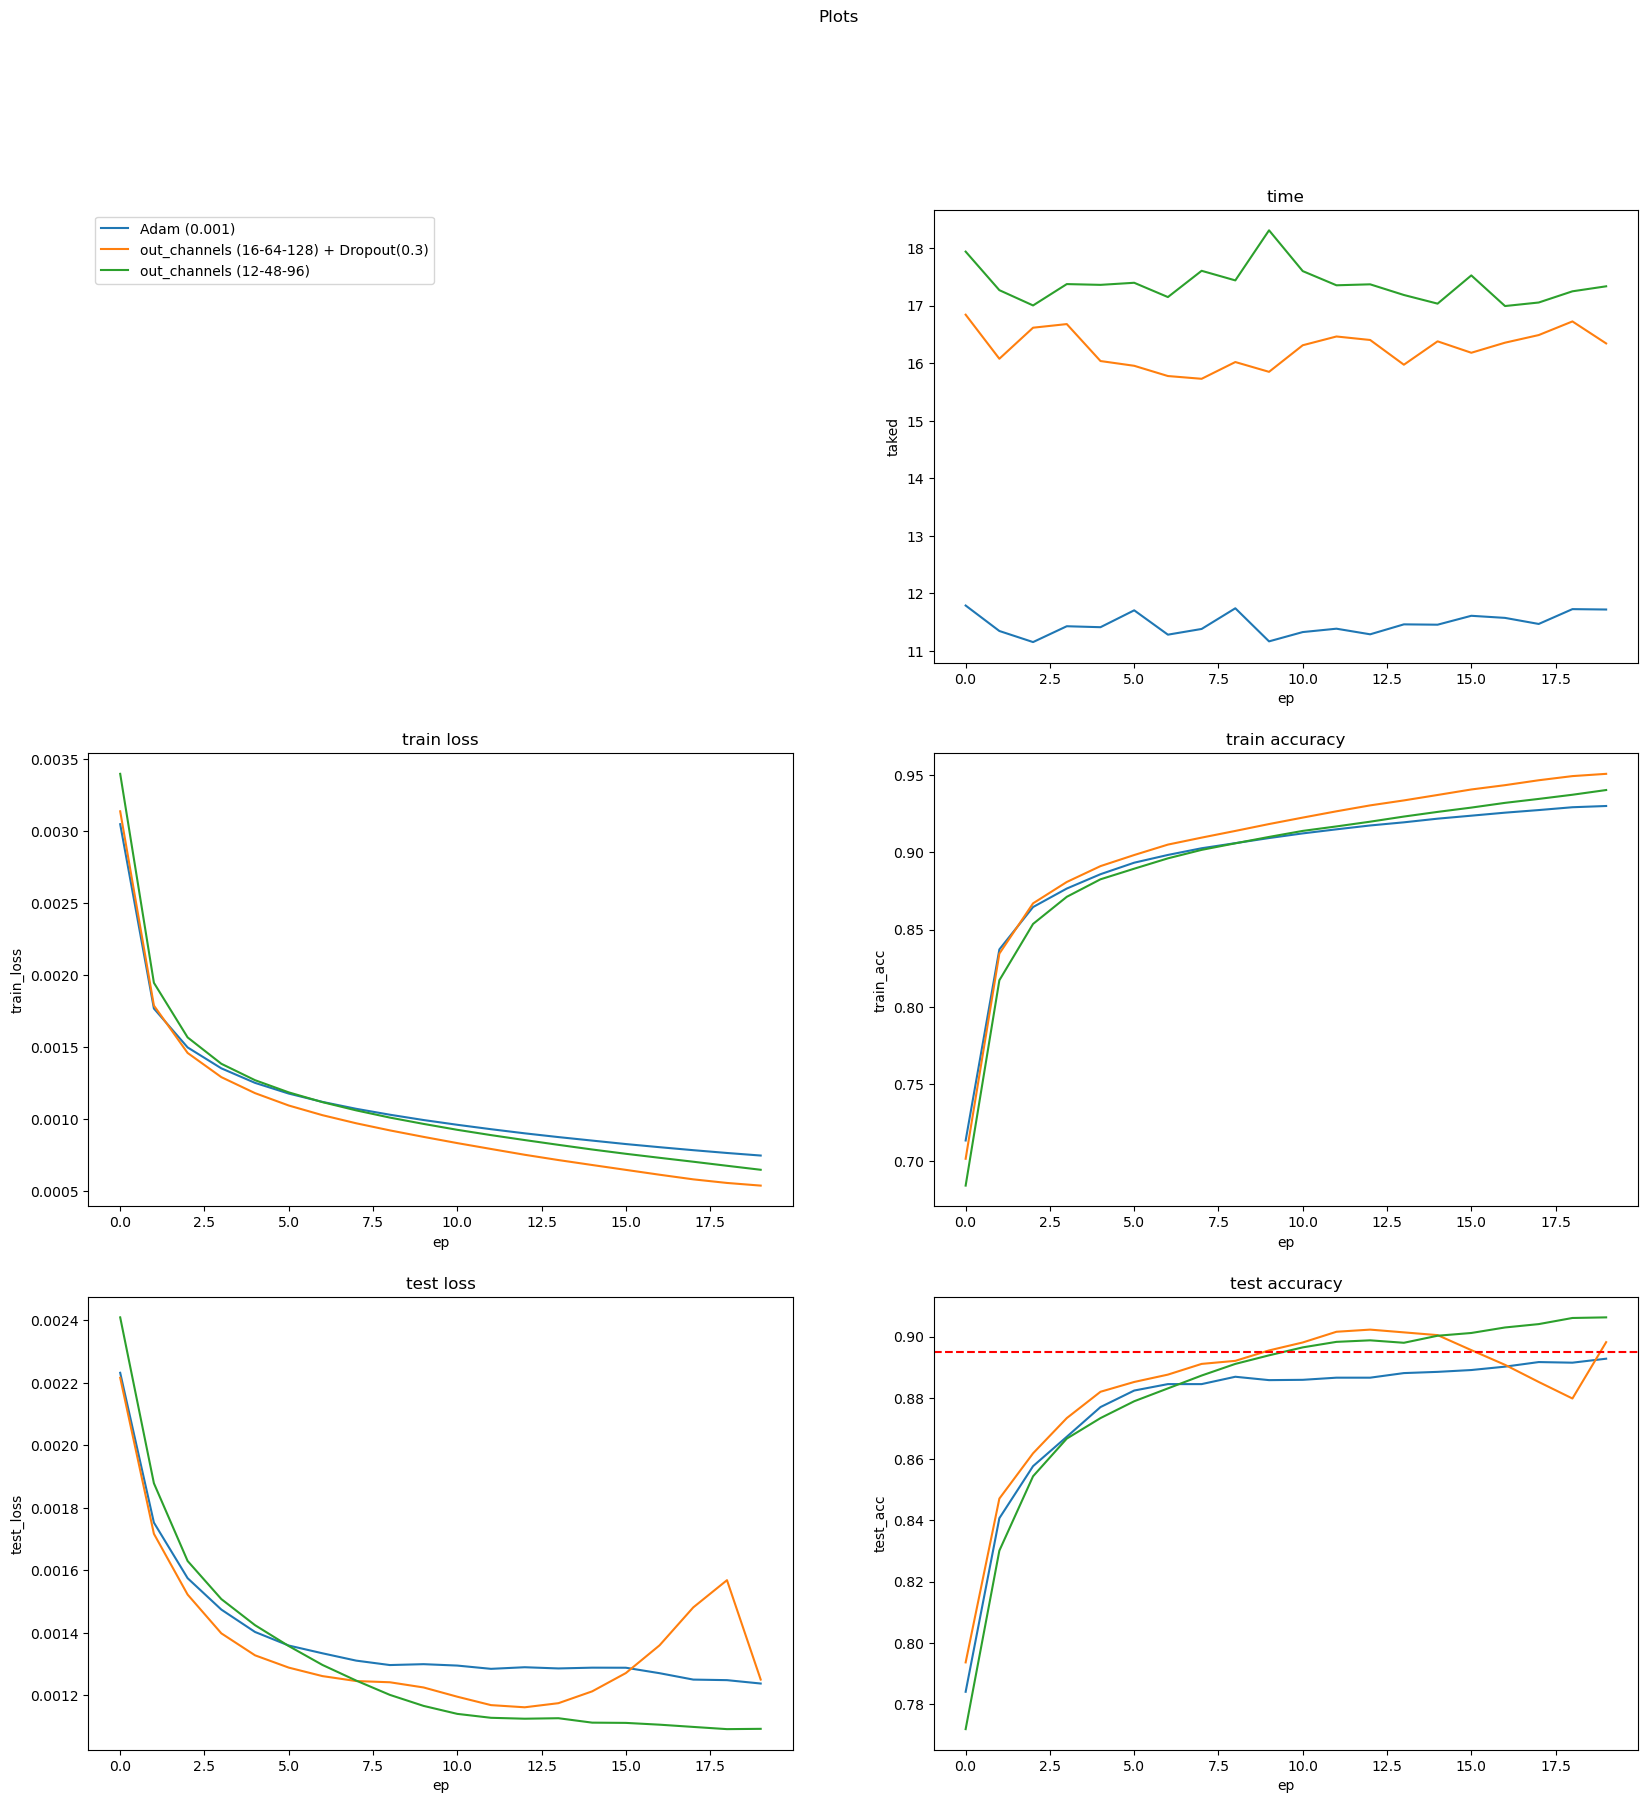

In [55]:
plt_show(model_dict, [
    'Adam (0.001)',
    'out_channels (16-64-128) + Dropout(0.3)',
    'out_channels (12-48-96)'
])

На 11 эпохе мы достигли цели (зеленый график), а именно
- корректно получены трейн и тест части
- сеть обучается (lest loss уменьшается, т.е. модель не переобучается)
- итоговое качество на тестовой выборке выше указанного в задании (test accuracy больше 89,5%)